### 1. 讀入套件

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow.keras.backend as K

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import losses
from tensorflow.keras import metrics

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

### 2. 讀入mnist資料

In [4]:
(x_train, y_train0), (x_test, y_test0) = mnist.load_data()

x_train = x_train.reshape(-1, 784) / 255
x_test = x_test.reshape(-1, 784) / 255

y_train = to_categorical(y_train0, 10)
y_test = to_categorical(y_test0, 10)

### 3. 建立encoder層

In [5]:
enc_1 = Dense(180, activation = 'sigmoid')

enc_mean = Dense(2)
enc_log_var = Dense(2)

dec_1 = Dense(180, activation = 'sigmoid')
dec_2 = Dense(784, activation = 'sigmoid')

In [6]:
x = Input(shape = (784,))
enc_x = enc_1(x)

z_mean = enc_mean(enc_x)
z_log_var = enc_log_var(enc_x)

### 4. 定義抽樣函式

In [7]:
def sampling(a):
    z_mean, z_log_var = a
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [8]:
z = Lambda(sampling, output_shape = (2,))([z_mean, z_log_var])

### 5. 定義decoder

In [11]:
x_hat = dec_2(dec_1(z))

### 6. 模型建立

In [12]:
VAE = Model(x, x_hat)
VAE.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 180)          141300      input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 2)            362         dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            362         dense[0][0]                      
______________________________________________________________________________________________

In [13]:
reconstruction_loss = 784 * losses.mean_squared_error(x, x_hat)
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis = 1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
VAE.add_loss(vae_loss)

### 7. 訓練模型

In [22]:
VAE.compile(optimizer = Adam())
VAE.fit(x_train, batch_size = 500, epochs = 10)

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 4s 61us/sample - loss: 45.4237
Epoch 2/10
60000/60000 [==============================] - 3s 45us/sample - loss: 45.1625
Epoch 3/10
60000/60000 [==============================] - 3s 43us/sample - loss: 44.9038
Epoch 4/10
60000/60000 [==============================] - 3s 46us/sample - loss: 44.6372
Epoch 5/10
60000/60000 [==============================] - 3s 46us/sample - loss: 44.3455
Epoch 6/10
60000/60000 [==============================] - 3s 46us/sample - loss: 44.0291
Epoch 7/10
60000/60000 [==============================] - 3s 43us/sample - loss: 43.7149
Epoch 8/10
60000/60000 [==============================] - 3s 46us/sample - loss: 43.4066
Epoch 9/10
60000/60000 [==============================] - 3s 44us/sample - loss: 43.1104
Epoch 10/10
60000/60000 [==============================] - 3s 45us/sample - loss: 42.8378


### 8. 視覺化

In [15]:
VAE_encoder = Model(x, z_mean)
VAE_encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 180)               141300    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 362       
Total params: 141,662
Trainable params: 141,662
Non-trainable params: 0
_________________________________________________________________


In [16]:
indices = np.random.randint(x_train.shape[0], size = 5000)
VAE_latents = VAE_encoder.predict(x_train[indices])

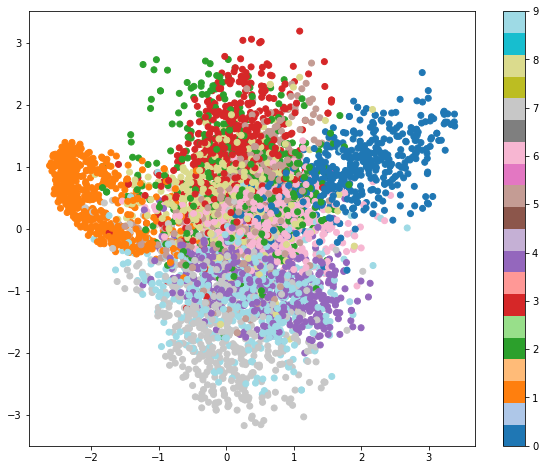

In [17]:
plt.figure(figsize = (10, 8))
plt.scatter(VAE_latents[:, 0], VAE_latents[:, 1], c = y_train0[indices], cmap = 'tab20')
plt.colorbar()
plt.show()

### 9. decoder視覺化

In [18]:
z_input = Input(shape = (2,))
VAE_decoder = Model(z_input, dec_2(dec_1(z_input)))
VAE_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 180)               540       
_________________________________________________________________
dense_4 (Dense)              (None, 784)               141904    
Total params: 142,444
Trainable params: 142,444
Non-trainable params: 0
_________________________________________________________________


In [19]:
def normalized(x):
    x -= x.min()
    x /= x.max()
    return x

In [20]:
n = 15
digit_size = 28
grid_x_vae = np.linspace(-4+0.05, 4-0.05, n)
grid_y_vae = np.linspace(-4+0.05, 4-0.05, n)
VAE_figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x_vae):
    for j, xi in enumerate(grid_y_vae):
        z_sample = np.array([[xi, yi]])
        x_decoded = VAE_decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        VAE_figure[(n-i-1) * digit_size: (n-i) * digit_size, j * digit_size: (j+1) * digit_size] = normalized(digit)

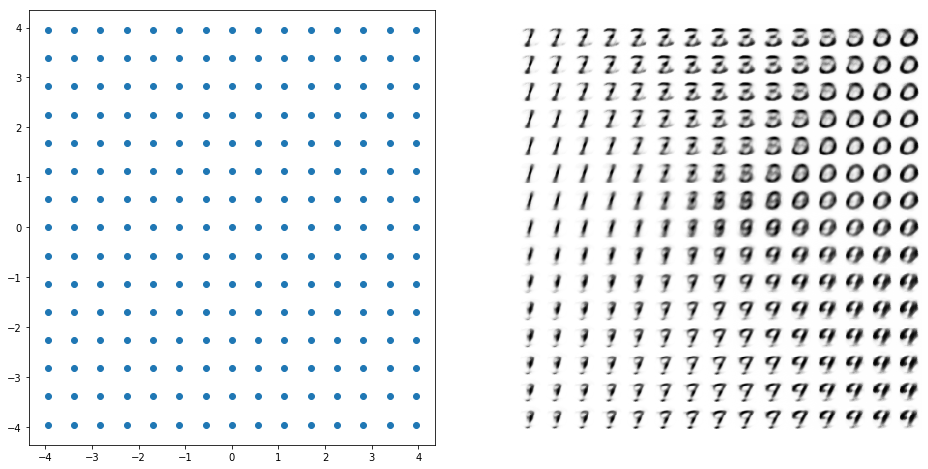

In [21]:
plt.figure(figsize = (16, 8))
plt.subplot(1, 2, 1)
XXX, YYY = np.meshgrid(grid_x_vae, grid_y_vae)
plt.scatter(XXX, YYY)

plt.subplot(1, 2, 2)
plt.imshow(VAE_figure, cmap = 'Greys')
plt.axis('off')
plt.show()